In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy 
import json
import networkx as nx
import pulp

import skopt
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

In [2]:
# Pulser imports
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice,DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig



In [3]:
from pulser.channels import DMM
from pulser.register.register_layout import RegisterLayout
from pulser.register.mappable_reg import MappableRegister
from pulser.register.weight_maps import DetuningMap

Evaluation Function

In [4]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))]) # x-y coordinates of houses
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]]) # position of the ith antenna
        for j in range(len(placement)):
            coord_j = np.array([placement[j]]) # position of the jth antenna
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist: # checking whether distance between ith and jth < 2R
                    cost += -B # penalising the cost function.


        dist = scipy.spatial.distance.cdist(coord_i, coords) # checking the distance between ith antenna and all houses.
        cov = np.sum(dist < R_dist) # checking whether the distance < R
        cost += cov # maximising cost function

    if cost < 0:
        return -np.inf
    else:
        return cost
    
R_antennas = 25

K-Means Lattice Generation

In [5]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[5]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])

population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_
antenna_pos = centers.copy()

Text(0.5, 1.0, 'Population of North Carl, N=1000')

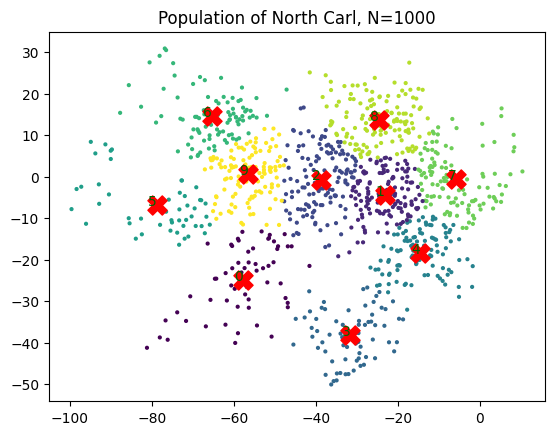

In [6]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))


Graph Generation

In [7]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

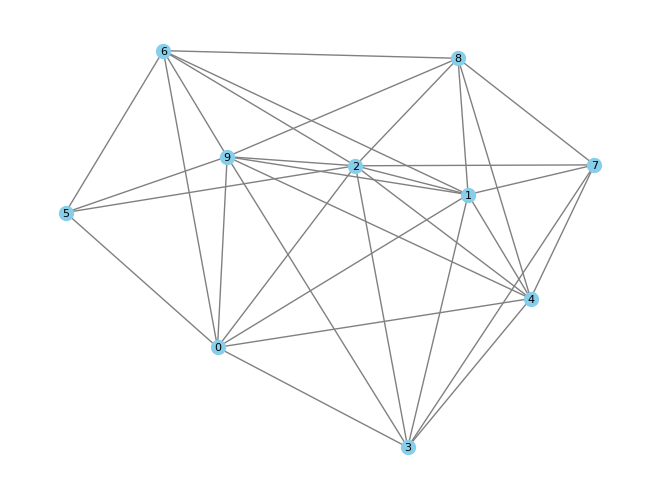

In [8]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', font_size=8)

In [10]:
adj_mtrx = nx.adjacency_matrix(G)
diagonal_elements = -1*np.diag(z_coverage)*np.eye(adj_mtrx.shape[0])
alpha = 1000
offdiagonal_elements = alpha*adj_mtrx.todense()
qubo = (diagonal_elements+offdiagonal_elements)/alpha
print(qubo)

[[-0.177  1.     1.     1.     1.     1.     1.     0.     0.     1.   ]
 [ 1.    -0.558  1.     1.     1.     0.     1.     1.     1.     1.   ]
 [ 1.     1.    -0.524  1.     1.     1.     1.     1.     1.     1.   ]
 [ 1.     1.     1.    -0.12   1.     0.     0.     1.     0.     1.   ]
 [ 1.     1.     1.     1.    -0.365  0.     0.     1.     1.     1.   ]
 [ 1.     0.     1.     0.     0.    -0.166  1.     0.     0.     1.   ]
 [ 1.     1.     1.     0.     0.     1.    -0.232  0.     1.     1.   ]
 [ 0.     1.     1.     1.     1.     0.     0.    -0.388  1.     0.   ]
 [ 0.     1.     1.     0.     1.     0.     1.     1.    -0.401  1.   ]
 [ 1.     1.     1.     1.     1.     1.     1.     0.     1.    -0.38 ]]


In [11]:
# Defining MIS Cost Function
## Get cost based on Q matix
def get_cost_Q(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

## Get avergae cost
def get_avg_cost(counter, Q):
    cost = sum(counter[key] * get_cost_Q(key, Q) for key in counter)
    return cost / sum(counter.values())

UDG Embedding

In [12]:
seed = 100
device_used = MockDevice

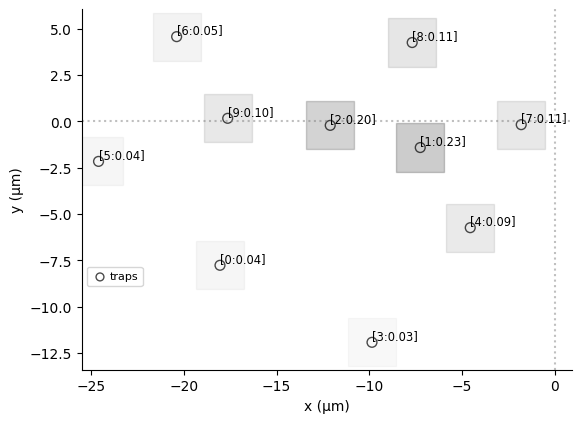

In [13]:
coords = antenna_pos.copy()
val = np.min(pdist(coords))
norm = 5/val
coords = coords*norm

qubits = dict(enumerate(coords))
reg = Register(qubits)
values = z_coverage
normalized_values = (values - values.min()) / (values.max() - values.min())
weights = np.exp(normalized_values * 2)  
weights /= weights.sum()

map ={idx:w for idx,w in zip(qubits.keys(),weights)} 
detuning_map = reg.define_detuning_map(map)
detuning_map.draw(list(qubits.keys()))

In [14]:
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)

In [15]:
seq = Sequence(reg, device_used)
seq.config_detuning_map(detuning_map, "dmm_0")
seq.declare_channel("ising", "rydberg_global")


In [16]:
from skopt.space import Real
from skopt.utils import use_named_args
search_space = list()
search_space.append(Real(np.median(Q[Q > 0]), np.max(Q), prior='log-uniform', name='omega-max'))
search_space.append(Real(-np.max(Q), 0, prior='uniform', name='delta_0'))
search_space.append(Real(0, np.max(Q), prior='uniform', name='delta_f'))
search_space.append(Real(100, 300, prior='uniform', name='t_rise'))
search_space.append(Real(800, 1500, prior='uniform', name='t_sweep'))
search_space.append(Real(100, 300, prior='uniform', name='t_fall'))
search_space.append(Real(0.01, 3.0, prior='uniform', name='detuning_strength'))

In [17]:
# Set noise configurations
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}

In [18]:
def create_ising_pulse(omega_max,delta_0,delta_f,t_rise,t_sweep,t_fall):
    t_total = t_rise+t_sweep+t_fall
    t_rise_norm = t_rise/ t_total
    t_sweep_norm = t_sweep / t_total
    t_fall_norm = t_fall / t_total

    detuning_wf = RampWaveform(duration=t_total, start=delta_0, stop=delta_f)

    amplitued_wf = InterpolatedWaveform(t_total,
                [0, omega_max, omega_max, 0],
                [0, t_rise_norm, t_rise_norm + t_sweep_norm, 1])

    rabi_pulse = Pulse(amplitude=amplitued_wf,detuning=detuning_wf,phase=0.0)

    return rabi_pulse

@use_named_args(search_space)
def objective_function(**params):
    omega_max = params['omega-max']
    delta_0 = params['delta_0']
    delta_f = params['delta_f']
    t_rise = params['t_rise']
    t_sweep = params['t_sweep']
    t_fall = params['t_fall']

    t_total = t_rise+t_sweep+t_fall
    t_rise_norm = t_rise/ t_total
    t_sweep_norm = t_sweep / t_total
    t_fall_norm = t_fall / t_total
    det_str = params['detuning_strength']

    det_wf = InterpolatedWaveform(t_total,
                [det_str*delta_0] * 4,
                [0, t_rise_norm, 1 - t_fall_norm, 1])

    seq = Sequence(reg, device_used)
    seq.config_detuning_map(detuning_map, "dmm_0")
    seq.declare_channel("ising", "rydberg_global")

    seq.add(create_ising_pulse(omega_max,delta_0,delta_f,t_rise,t_sweep,t_fall),"ising","no-delay")
    seq.add_dmm_detuning(ConstantWaveform(duration=t_total,value=det_str*delta_0), "dmm_0")
    #seq.add_dmm_detuning(det_wf, "dmm_0")
    simulator = QutipEmulator.from_sequence(sequence = seq,
                                            sampling_rate = 0.01,
                                            with_modulation = False,
                                            config = noise_config["noiseless"],
                                            )

    simulator.show_config()
    results = simulator.run(progress_bar = True)
    count_dict = results.sample_final_state(N_samples = 1000)

    cost = get_avg_cost(count_dict, qubo)

    return cost

In [ ]:
from skopt import gp_minimize

result = gp_minimize(
    func=objective_function,    # Objective function
    dimensions=search_space,    # Search space
    n_calls=50,                 # Number of evaluations
    random_state=0              # For reproducibility
)


C:\Users\navan\AppData\Local\Temp\ipykernel_1896\3989530278.py:7: UserWarning: A waveform duration of 1759.8001964036303 ns is below the supported precision of 1 ns. It was rounded down to 1759 ns.
  detuning_wf = RampWaveform(duration=t_total, start=delta_0, stop=delta_f)
C:\Users\navan\AppData\Local\Temp\ipykernel_1896\3989530278.py:9: UserWarning: A waveform duration of 1759.8001964036303 ns is below the supported precision of 1 ns. It was rounded down to 1759 ns.
  amplitued_wf = InterpolatedWaveform(t_total,
C:\Users\navan\AppData\Local\Temp\ipykernel_1896\1564662927.py:2: UserWarning: A waveform duration of 1759.8001964036303 ns is below the supported precision of 1 ns. It was rounded down to 1759 ns.
  seq.add_dmm_detuning(ConstantWaveform(duration=sum(result.x[3:6]),value=result.x[6]*result.x[1]), "dmm_0")


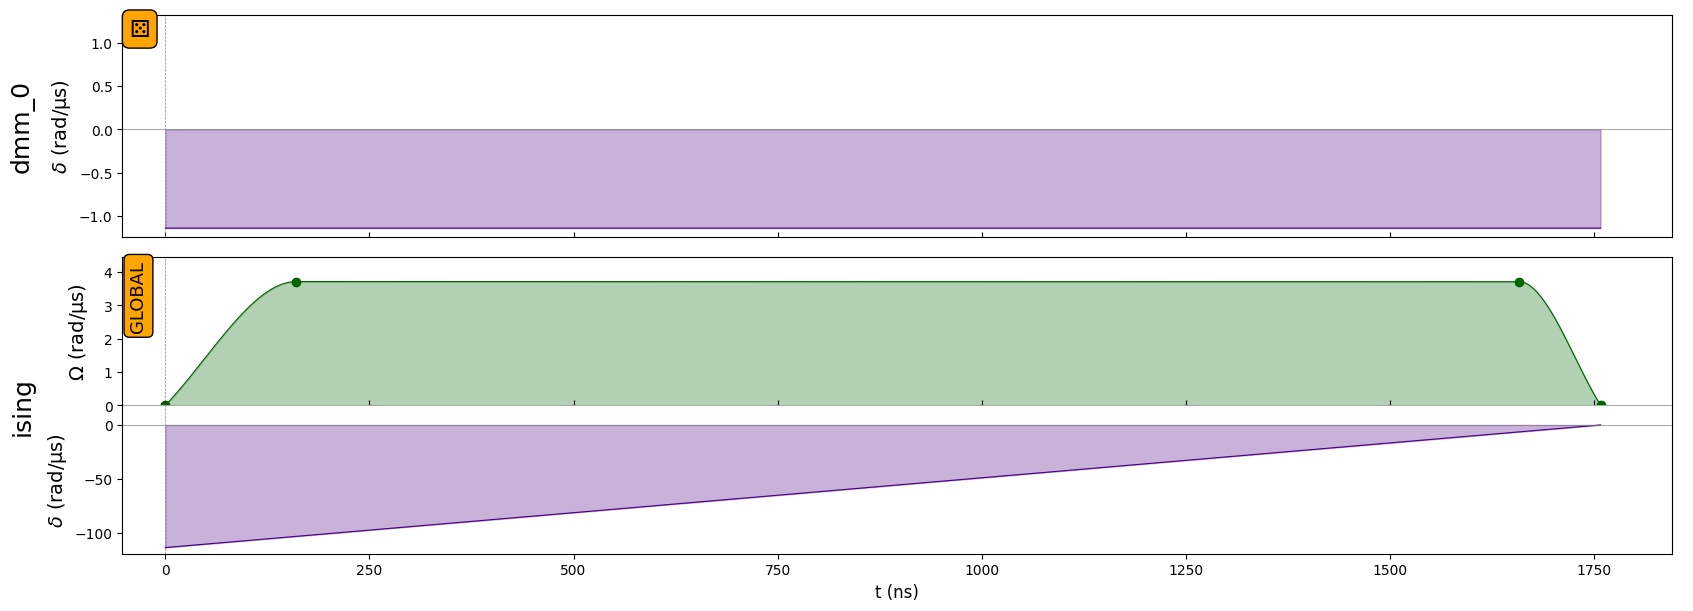

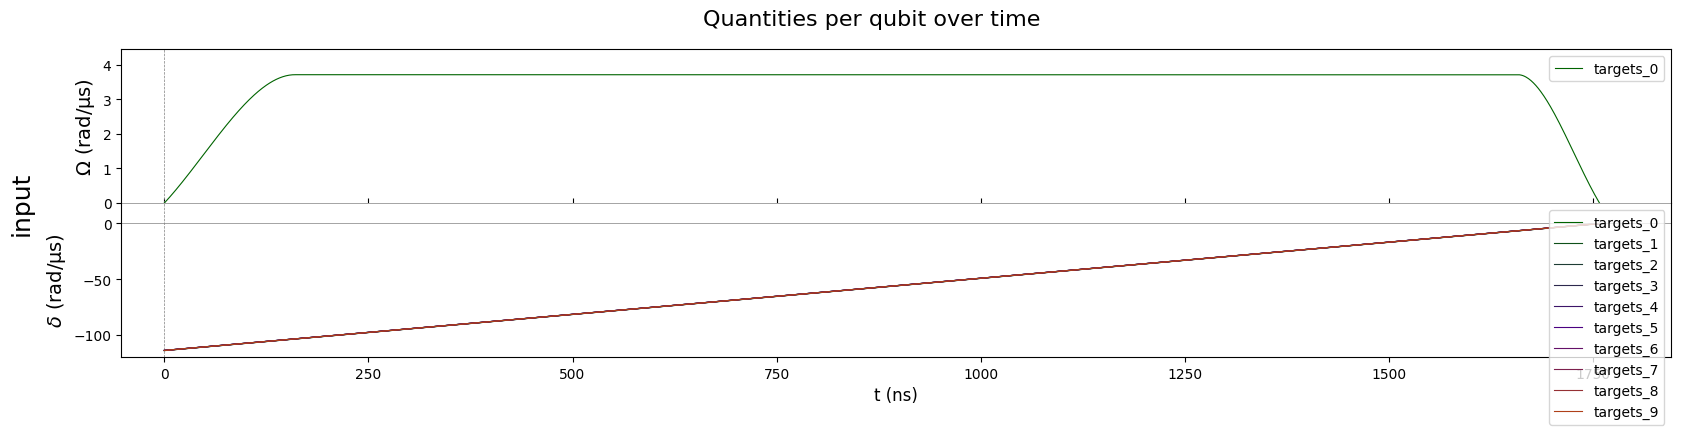

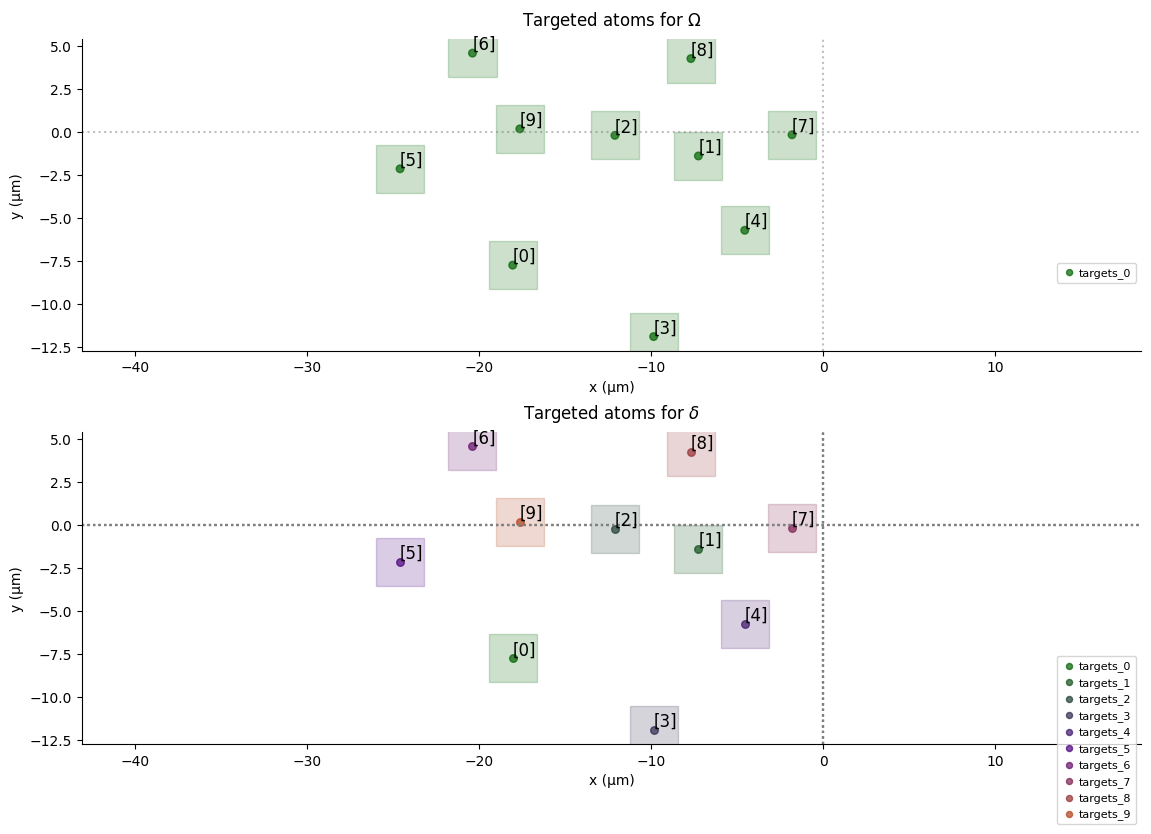

In [20]:
seq.add(create_ising_pulse(*result.x[:-1]),"ising","no-delay")
seq.add_dmm_detuning(ConstantWaveform(duration=sum(result.x[3:6]),value=result.x[6]*result.x[1]), "dmm_0")

seq.draw(
    mode="input+output",  # "input" only shows input signals, "input+output"
    draw_qubit_det=True,
    draw_qubit_amp=True,
)

In [80]:
det_wf = InterpolatedWaveform(sum(result.x[3:6]),
                [result.x[6]*result.x[1]] * 4,
                [0, result.x[3]/sum(result.x[3:6]), 1 - (result.x[5]/sum(result.x[3:6])), 1])
seq.add(create_ising_pulse(*result.x[:-1]),"ising","no-delay")
seq.add_dmm_detuning(det_wf, "dmm_0")
                     

C:\Users\navan\AppData\Local\Temp\ipykernel_9264\1279394834.py:1: UserWarning: A waveform duration of 1371.8193454083207 ns is below the supported precision of 1 ns. It was rounded down to 1371 ns.
  det_wf = InterpolatedWaveform(sum(result.x[3:6]),
C:\Users\navan\AppData\Local\Temp\ipykernel_9264\2719203202.py:7: UserWarning: A waveform duration of 1371.8193454083207 ns is below the supported precision of 1 ns. It was rounded down to 1371 ns.
  detuning_wf = RampWaveform(duration=t_total, start=delta_0, stop=delta_f)
C:\Users\navan\AppData\Local\Temp\ipykernel_9264\2719203202.py:9: UserWarning: A waveform duration of 1371.8193454083207 ns is below the supported precision of 1 ns. It was rounded down to 1371 ns.
  amplitued_wf = InterpolatedWaveform(t_total,


In [21]:
simulator = QutipEmulator.from_sequence(sequence = seq,
                                            sampling_rate = 0.01,
                                            with_modulation = False,
                                            config = noise_config["noiseless"],
                                            )

simulator.show_config()
results = simulator.run(progress_bar = True)
count_dict = results.sample_final_state(N_samples = 1000)


Options:
----------
Number of runs:        15
Samples per run:       5
11.8%. Run time:   0.25s. Est. time left: 00:00:00:01
23.5%. Run time:   0.74s. Est. time left: 00:00:00:02
35.3%. Run time:   1.29s. Est. time left: 00:00:00:02
41.2%. Run time:   1.52s. Est. time left: 00:00:00:02
52.9%. Run time:   2.03s. Est. time left: 00:00:00:01
64.7%. Run time:   2.48s. Est. time left: 00:00:00:01
70.6%. Run time:   2.70s. Est. time left: 00:00:00:01
82.4%. Run time:   3.06s. Est. time left: 00:00:00:00
94.1%. Run time:   3.40s. Est. time left: 00:00:00:00
Total run time:   3.40s


In [22]:
count_dict

Counter({'0000000000': 583,
         '0000000001': 30,
         '0000000010': 40,
         '0000000011': 2,
         '0000000100': 27,
         '0000000101': 1,
         '0000001000': 30,
         '0000001010': 3,
         '0000001100': 1,
         '0000010000': 33,
         '0000010010': 3,
         '0000010100': 3,
         '0000100000': 37,
         '0000100001': 6,
         '0000101000': 1,
         '0000110000': 2,
         '0001000000': 47,
         '0001000001': 1,
         '0001000010': 4,
         '0001000100': 1,
         '0001001000': 2,
         '0001001100': 1,
         '0001010000': 1,
         '0001010100': 1,
         '0001100000': 1,
         '0010000000': 40,
         '0010010000': 2,
         '0010100000': 1,
         '0011000000': 1,
         '0100000000': 31,
         '0100001000': 3,
         '1000000000': 41,
         '1000000010': 4,
         '1000000100': 1,
         '1000001000': 5,
         '1000100000': 3,
         '1000110000': 1,
         '1001000000': 1,
